# Pandas vs. PyArrow file reading speed comparison
## April, 2021

---

In [66]:
import time
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pyarrow.parquet as pq
import os
import sys
import matplotlib as mpl
mpl.rcParams['figure.dpi']=125

## Create CSV files of various sizes

In [2]:
for i in range(1,11):
    a = np.random.normal(size=(int(5325*i), int(1e2)))
    df = pd.DataFrame(a, columns=["C" + str(i) for i in range(100)])
    fname = "test"+str(i)+".csv"
    df.to_csv(fname)
    print(f"Size of file with {5325*i} rows: {round(os.path.getsize(fname)/(1024*1024),3)} MB")

Size of file with 5325 rows: 9.999 MB
Size of file with 10650 rows: 19.999 MB
Size of file with 15975 rows: 30.003 MB
Size of file with 21300 rows: 40.01 MB
Size of file with 26625 rows: 50.014 MB
Size of file with 31950 rows: 60.02 MB
Size of file with 37275 rows: 70.024 MB
Size of file with 42600 rows: 80.03 MB
Size of file with 47925 rows: 90.033 MB
Size of file with 53250 rows: 100.039 MB


## Create Parquet (compressed) files from the same CSV files

In [3]:
for i in range(1,11):
    fname = "test"+str(i)+".csv"
    parquet_name = "test"+str(i)+"_parquet.zip"
    df = pd.read_csv(fname)
    df.to_parquet(parquet_name,compression="gzip")
    print(f"Created {parquet_name}")

Created test1_parquet.zip
Created test2_parquet.zip
Created test3_parquet.zip
Created test4_parquet.zip
Created test5_parquet.zip
Created test6_parquet.zip
Created test7_parquet.zip
Created test8_parquet.zip
Created test9_parquet.zip
Created test10_parquet.zip


The directory should look like this now...

![dir](https://raw.githubusercontent.com/tirthajyoti/Machine-Learning-with-Python/master/Pandas%20and%20Numpy/Read_data_various_sources/dir.PNG)

---

## Reading speed of CSV (in Pandas) and Parquet files (with `PyArrow`)

In [76]:
t_read_pd,t_read_arrow = [],[]

for i in range(1,11):
    fname = "test"+str(i)+".csv"
    parquet_name = "test"+str(i)+"_parquet.zip"
    t1 = time.time()
    df1 = pd.read_csv(fname)
    t2 = time.time()
    delta_t = round((t2 - t1), 3)
    t_read_pd.append(delta_t)
    t1 = time.time()
    df2 = pq.read_table(parquet_name)
    t2 = time.time()
    delta_t = round((t2 - t1), 3)
    t_read_arrow.append(delta_t)
    print(f"Done for file # {i}")

Done for file # 1
Done for file # 2
Done for file # 3
Done for file # 4
Done for file # 5
Done for file # 6
Done for file # 7
Done for file # 8
Done for file # 9
Done for file # 10


In [77]:
t_read_pd = np.array(t_read_pd)
t_read_arrow = np.array(t_read_arrow)

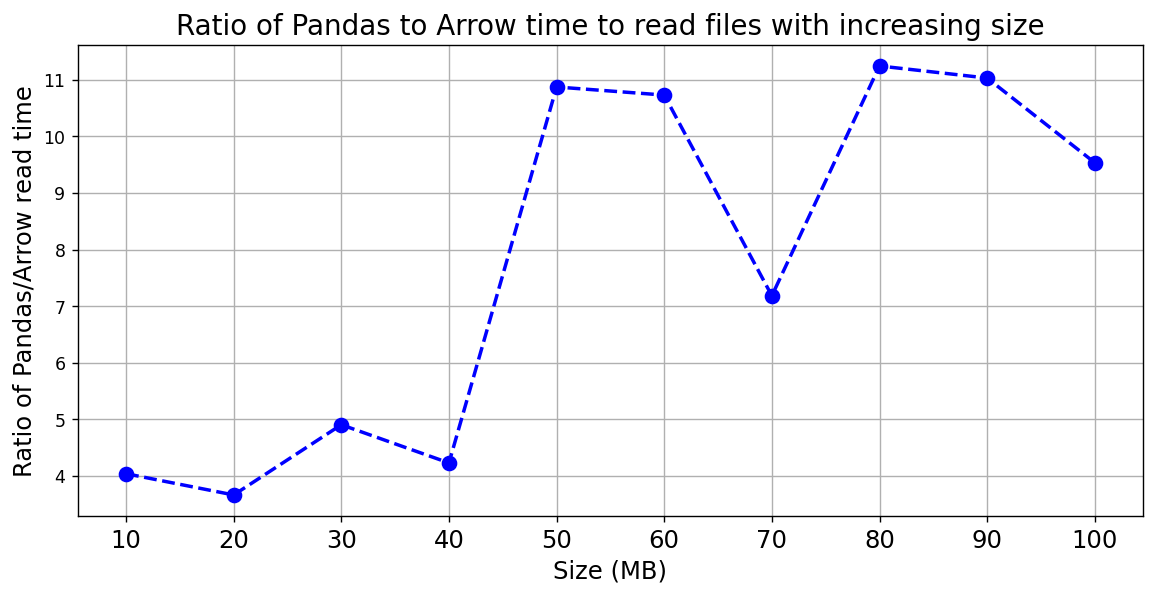

In [78]:
plt.figure(figsize=(11, 5))
plt.plot(
    [10*i for i in range(1, 11)], t_read_pd/t_read_arrow, "bo--", linewidth=2, markersize=8
)
plt.grid(True)
plt.title(
    "Ratio of Pandas to Arrow time to read files with increasing size",
    fontsize=16,
)
plt.xticks([10*i for i in range(1, 11)],fontsize=14)
plt.xlabel("Size (MB)", fontsize=14)
plt.ylabel("Ratio of Pandas/Arrow read time", fontsize=14)
plt.show()

---

## What's the order of read time? Seconds, milliseconds?

In [79]:
t1 = time.time()
df1 = pd.read_csv("test10.csv", usecols=["C1", "C99"])
t2 = time.time()
delta_t = round((t2 - t1), 3)
print(
    "Time taken to read 2 columns of a 100 MB (53250 rows) CSV file with Pandas:",
    delta_t,
    "seconds",
)

Time taken to read 2 columns of a 100 MB (53250 rows) CSV file with Pandas: 1.114 seconds


#### The reading speed of the 100 MB CSV file with `pd.read_csv()` is about 1.114 seconds.

In [80]:
df1.head()

,C1,C99
0,-0.692951,-0.799652
1,-1.065218,-0.200694
2,0.023773,-1.928832
3,-0.298594,-1.340441
4,1.021031,0.295909


In [81]:
t1 = time.time()
df2 = pq.read_table("test10_parquet.zip", columns=["C1", "C99"])
t2 = time.time()
delta_t = round((t2 - t1), 3)
print(
    "Time taken to read 2 columns of the identical 53250 rows zipped parquet file with PyArrow:",
    delta_t,
    "seconds",
)

Time taken to read 2 columns of the identical 53250 rows zipped parquet file with PyArrow: 0.026 seconds


#### The reading speed of the same file (in the parquet gzipped version) with `pq.read_table()` is about 0.026 seconds!

In [82]:
# Convert from PyArrow table to dataframe
df3 = df2.to_pandas()
df3.head()

,C1,C99
0,-0.692951,-0.799652
1,-1.065218,-0.200694
2,0.023773,-1.928832
3,-0.298594,-1.340441
4,1.021031,0.295909


#### The dataframes `df1` and `df3` are the same, as expected.

---

## Reading a small number of columns is much faster with Arrow

In [83]:
all_cols = ["C" + str(i) for i in range(100)]
t_pandas, t_arrow = [], []
for i in range(2, 100, 2):
    cols = list(np.random.choice(all_cols, size=i))
    t1 = time.time()
    df1 = pd.read_csv("test10.csv", usecols=cols)
    t2 = time.time()
    delta_t_pandas = round((t2 - t1), 3)
    t_pandas.append(delta_t_pandas)
    t1 = time.time()
    df2 = pq.read_table("test10_parquet.zip", columns=cols)
    t2 = time.time()
    delta_t_arrow = round((t2 - t1), 3)
    t_arrow.append(delta_t_arrow)
    print(f"Done for {i} columns")

Done for 2 columns
Done for 4 columns
Done for 6 columns
Done for 8 columns
Done for 10 columns
Done for 12 columns
Done for 14 columns
Done for 16 columns
Done for 18 columns
Done for 20 columns
Done for 22 columns
Done for 24 columns
Done for 26 columns
Done for 28 columns
Done for 30 columns
Done for 32 columns
Done for 34 columns
Done for 36 columns
Done for 38 columns
Done for 40 columns
Done for 42 columns
Done for 44 columns
Done for 46 columns
Done for 48 columns
Done for 50 columns
Done for 52 columns
Done for 54 columns
Done for 56 columns
Done for 58 columns
Done for 60 columns
Done for 62 columns
Done for 64 columns
Done for 66 columns
Done for 68 columns
Done for 70 columns
Done for 72 columns
Done for 74 columns
Done for 76 columns
Done for 78 columns
Done for 80 columns
Done for 82 columns
Done for 84 columns
Done for 86 columns
Done for 88 columns
Done for 90 columns
Done for 92 columns
Done for 94 columns
Done for 96 columns
Done for 98 columns


In [12]:
t_pandas = np.array(t_pandas)
t_arrow = np.array(t_arrow)

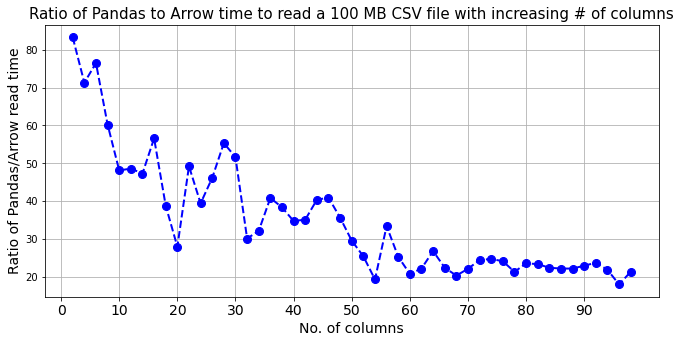

In [13]:
plt.figure(figsize=(11, 5))
plt.plot(
    [i for i in range(2, 100, 2)], t_pandas / t_arrow, "bo--", linewidth=2, markersize=8
)
plt.grid(True)
plt.title(
    "Ratio of Pandas to Arrow time to read a 100 MB CSV file with increasing # of columns",
    fontsize=15,
)
plt.xticks([i for i in range(0, 100, 10)],fontsize=14)
plt.xlabel("No. of columns", fontsize=14)
plt.ylabel("Ratio of Pandas/Arrow read time", fontsize=14)
plt.show()

In [45]:
pct_nan = []
for i in range(11,21):
    a = np.random.normal(size=(int(5325*5), int(1e2)))
    cutoff = -2+0.4*(i-11)
    a = np.where(a < cutoff, np.nan, a)
    p_nan = round(100*np.count_nonzero(np.isnan(a))/a.size,2)
    pct_nan.append(p_nan)
    df = pd.DataFrame(a, columns=["C" + str(i) for i in range(100)])
    fname = "test"+str(i)+".csv"
    df.to_csv(fname)
    print(f"NaN-filled file written with {p_nan}%")

NaN-filled file written with 2.28%
NaN-filled file written with 5.49%
NaN-filled file written with 11.49%
NaN-filled file written with 21.21%
NaN-filled file written with 34.45%
NaN-filled file written with 50.04%
NaN-filled file written with 65.54%
NaN-filled file written with 78.81%
NaN-filled file written with 88.5%
NaN-filled file written with 94.53%


In [46]:
for i in range(11,21):
    fname = "test"+str(i)+".csv"
    parquet_name = "test"+str(i)+"_parquet.zip"
    df = pd.read_csv(fname)
    df.to_parquet(parquet_name,compression="gzip")
    print(f"Created {parquet_name}")

Created test11_parquet.zip
Created test12_parquet.zip
Created test13_parquet.zip
Created test14_parquet.zip
Created test15_parquet.zip
Created test16_parquet.zip
Created test17_parquet.zip
Created test18_parquet.zip
Created test19_parquet.zip
Created test20_parquet.zip


In [52]:
t_read_nan = []
m_read_nan = []

for i in range(11,21):
    parquet_name = "test"+str(i)+"_parquet.zip"
    t1 = time.time()
    df2 = pq.read_table(parquet_name)
    t2 = time.time()
    delta_t = round(1000*(t2 - t1), 3)
    t_read_nan.append(delta_t)
    m_read_nan.append()
    print(f"Done for file # {i}")
t_read_nan=np.array(t_read_nan)

Done for file # 11
Done for file # 12
Done for file # 13
Done for file # 14
Done for file # 15
Done for file # 16
Done for file # 17
Done for file # 18
Done for file # 19
Done for file # 20


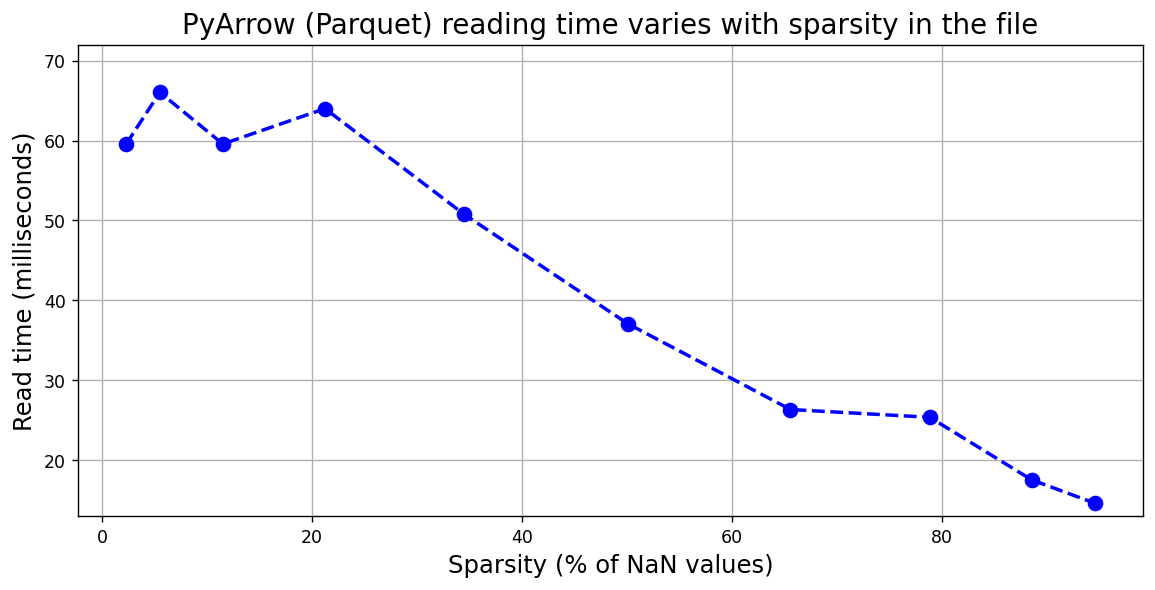

In [59]:
plt.figure(figsize=(11, 5))
plt.plot(pct_nan,t_read_nan, "bo--", linewidth=2, markersize=8)
plt.grid(True)
plt.title("PyArrow (Parquet) reading time varies with sparsity in the file",fontsize=16,)
#plt.xticks([10*i for i in range(1, 11)],fontsize=14)
plt.xlabel("Sparsity (% of NaN values)", fontsize=14)
plt.ylabel("Read time (milliseconds)", fontsize=14)
plt.ylim(int(t_read_nan.min()*0.9),int(t_read_nan.max()*1.1))
plt.show()

In [60]:
t_pd_nan = []
for i in range(11,21):
    fname = "test"+str(i)+".csv"
    t1 = time.time()
    df2 = pd.read_csv(fname)
    t2 = time.time()
    delta_t = round(1000*(t2 - t1), 3)
    t_pd_nan.append(delta_t)
    print(f"Done for file # {i}")
t_pd_nan=np.array(t_pd_nan)

Done for file # 11
Done for file # 12
Done for file # 13
Done for file # 14
Done for file # 15
Done for file # 16
Done for file # 17
Done for file # 18
Done for file # 19
Done for file # 20


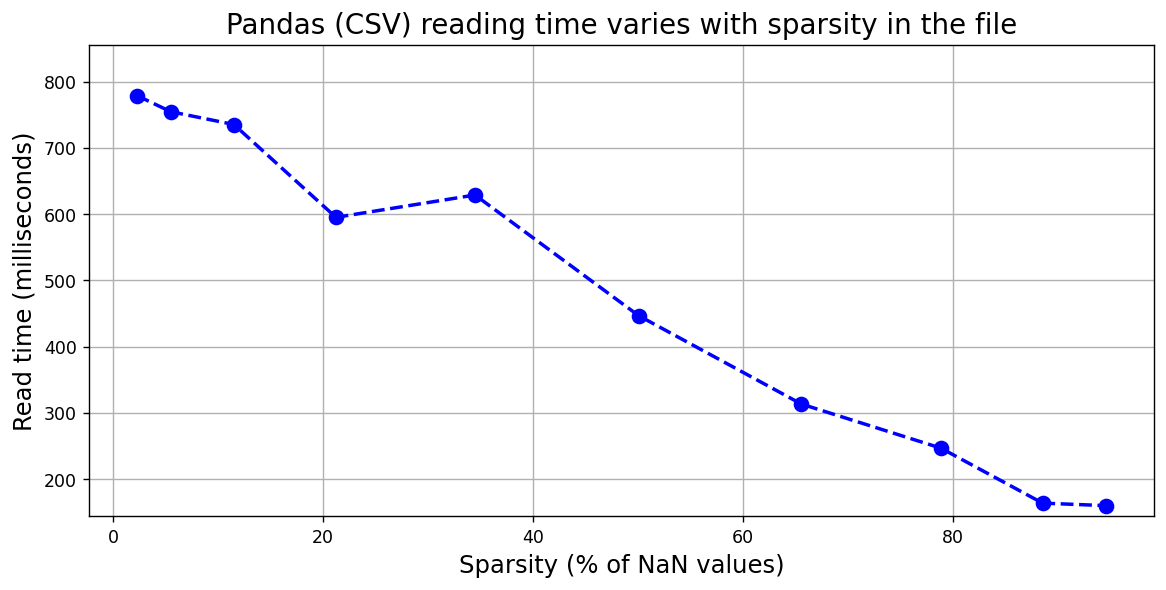

In [61]:
plt.figure(figsize=(11, 5))
plt.plot(pct_nan,t_pd_nan, "bo--", linewidth=2, markersize=8)
plt.grid(True)
plt.title("Pandas (CSV) reading time varies with sparsity in the file",fontsize=16,)
#plt.xticks([10*i for i in range(1, 11)],fontsize=14)
plt.xlabel("Sparsity (% of NaN values)", fontsize=14)
plt.ylabel("Read time (milliseconds)", fontsize=14)
plt.ylim(int(t_pd_nan.min()*0.9),int(t_pd_nan.max()*1.1))
plt.show()